# Referee Report Major Comment #2
One of the reasons for spectroscopically-derived SFR is to obtain a cleaner separation between SF and quiescent galaxies at z~0 than a simple color cut. However, the quiescent fractions at higher redshift taken from Tinker et al. 2013 were obtained using NUV-R and R-J color-color cut. Would these different classification methods at different redshifts affect the results? The authors could separate the SF and quiescent galaxies at z~0 using a color cut similar to that in Tinker et al. 2013 to check this.

In [1]:
import numpy as np
import h5py
import pickle
from pydl.pydlutils.spheregroup import spherematch

import matplotlib.pyplot as plt
%matplotlib inline 

from ChangTools.fitstables import mrdfits
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import os

if os.path.isdir('/Volumes/ChangHDD/project/cenque/observations/'): 
    local_dir = '/Volumes/ChangHDD/project/cenque/observations/'
elif os.path.isdir('/Volumes/750GB/hahn/cenque/observations/'): 
    local_dir = '/Volumes/750GB/hahn/cenque/observations/'
print local_dir

/Volumes/750GB/hahn/cenque/observations/


## Import combined catalog of NSA + GALEX + 2MASS (NGT)
with absolute magnitudes from K-correct to $z = 0$. 

In [3]:
# ideally, this fits file would have had all the necessary info but I couldn't get IDL to work properly so 
# this file only contains the spherematch-ed fluxes and absolute magnitudes...
fits_data = mrdfits(''.join([local_dir, 'nsa_galex_2mass_kcorrect.sersics.fits']))

catalog = {}
for key in fits_data.__dict__.keys(): 
    catalog[key] = getattr(fits_data, key)
print sorted(catalog.keys())

['absmag', 'absmag_ivar', 'dec', 'k_coeff', 'k_maggies', 'k_mass', 'k_mtol', 'kcorrect', 'maggies', 'maggies_ivar', 'ra', 'z']


In [5]:
# VAGC group catalog (all) M_r cut = 18
vagc_file = ''.join([local_dir, 'GroupCat.Mr18.Mass9.4.D360.all.hdf5']) 
f = h5py.File(vagc_file, 'r')
grp = f['data']

# save to dictionary
vagc = {}
for key in grp.keys(): 
    vagc[key] = grp[key].value

## Cross match NGT catalog with VAGC catalog

In [7]:
# spherematch VAGC catalog with the combined NGT catalgo
m_vagc_ngt, m_ngt_vagc, dd = spherematch(vagc['ra'], vagc['dec'], catalog['ra'], catalog['dec'], 0.0003)
print 'VAGC: ', len(vagc['ra']), ' galaxies'
print 'NGT: ', len(catalog['ra']), ' galaxies'
print len(m_vagc_ngt), ' matches'

VAGC:  21423  galaxies
NGT:  122375
20131  matches


In [12]:
# get absmags for VAGC from NGT catalog 
for key in ['absmag', 'absmag_ivar']: 
    vagc[key] = np.zeros((10, len(vagc['ra']))) - 999.
    vagc[key][:, m_vagc_ngt] = catalog[key].T[:, m_ngt_vagc]

In [13]:
# calculate NUV-R and R-J from the absmags
vagc['NUV-R'] = np.zeros(len(vagc['ra'])) - 999.
vagc['R-J'] = np.zeros(len(vagc['ra'])) - 999.

vagc['NUV-R'][m_vagc_ngt] = vagc['absmag'][1,m_vagc_ngt] - vagc['absmag'][4,m_vagc_ngt]
vagc['R-J'][m_vagc_ngt] = vagc['absmag'][4,m_vagc_ngt] - vagc['absmag'][7,m_vagc_ngt]


(-3.0, 2.0)

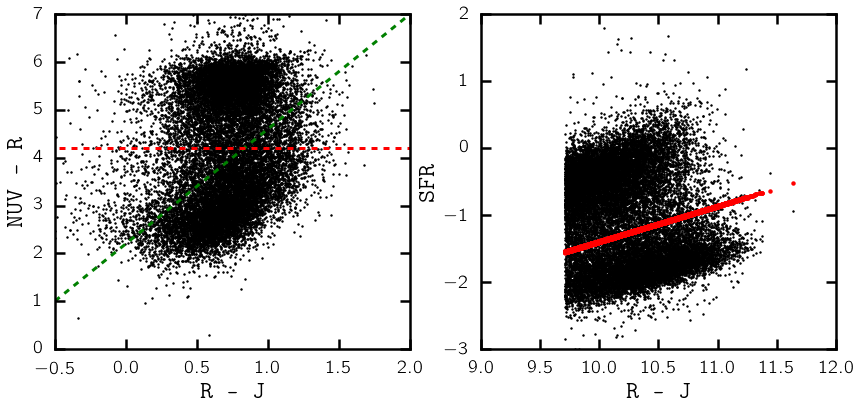

In [31]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(14,6))
sub = fig.add_subplot(121)
sub.scatter(vagc['R-J'][m_vagc_ngt], vagc['NUV-R'][m_vagc_ngt], c='k', s=2)

# these following lines are 'extrapolated' from Bundy et al. (2010). However, the photometry
# used in Bundy et al. (2010) is quite different than GALEX, SDSS, 2MASS, so these cuts are 
# pretty arbitrary... But they seem to be relatively consistent with the "valleys" in the 
# data contours... dear god this is sloppy
sub.plot(np.arange(-1., 3., 0.1), 2.2 + 2.4*np.arange(-1., 3., 0.1), c='g', lw=3, ls='--')
sub.plot(np.arange(-1., 3., 0.1), 4.2 + 0.*np.arange(-1., 3.,0.1), c='r', lw=3, ls='--')

sub.set_xlabel('R - J', fontsize=25)
sub.set_xlim([-0.5, 2.])
sub.set_ylabel('NUV - R', fontsize=25)
sub.set_ylim([0., 7.])

sub = fig.add_subplot(122)
sub.scatter(vagc['mass'][m_vagc_ngt], vagc['sfr'][m_vagc_ngt], c='k', s=2)
sub.scatter(vagc['mass'][m_vagc_ngt], 0.53 * (vagc['mass'][m_vagc_ngt] - 10.5)+ 1.1 * (vagc['z'][m_vagc_ngt] - 0.0502) - 1.11, 
         c='r', lw=0)

sub.set_xlabel('R - J', fontsize=25)
sub.set_xlim([9., 12.])
sub.set_ylabel('SFR', fontsize=25)
sub.set_ylim([-3., 2.])

### Where do the galaxies classified as quenched from $SFR - M_*$ cuts reside?

In [22]:
# SFR-M* cuts to define quiescent galaxies
sfrm_Q = np.where(vagc['sfr'][m_vagc_ngt] < 0.53 * (vagc['mass'][m_vagc_ngt] - 10.5)+ 1.1 * (vagc['z'][m_vagc_ngt] - 0.0502) - 1.11)

(-3.0, 2.0)

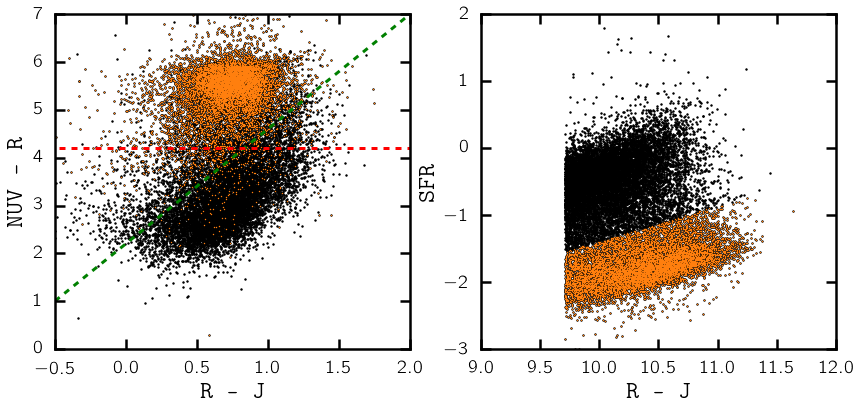

In [32]:
fig = plt.figure(figsize=(14,6))
sub = fig.add_subplot(121)
sub.scatter(vagc['R-J'][m_vagc_ngt], vagc['NUV-R'][m_vagc_ngt], c='k', s=2)

sub.scatter(vagc['R-J'][m_vagc_ngt][sfrm_Q], vagc['NUV-R'][m_vagc_ngt][sfrm_Q], c=pretty_colors[3], lw=0, s=2)

# these following lines are 'extrapolated' from Bundy et al. (2010). However, the photometry
# used in Bundy et al. (2010) is quite different than GALEX, SDSS, 2MASS, so these cuts are 
# pretty arbitrary... But they seem to be relatively consistent with the "valleys" in the 
# data contours... dear god this is sloppy
sub.plot(np.arange(-1., 3., 0.1), 2.2 + 2.4*np.arange(-1., 3., 0.1), c='g', lw=3, ls='--')
sub.plot(np.arange(-1., 3., 0.1), 4.2 + 0.*np.arange(-1., 3.,0.1), c='r', lw=3, ls='--')

sub.set_xlabel('R - J', fontsize=25)
sub.set_xlim([-0.5, 2.])
sub.set_ylabel('NUV - R', fontsize=25)
sub.set_ylim([0., 7.])

sub = fig.add_subplot(122)
sub.scatter(vagc['mass'][m_vagc_ngt], vagc['sfr'][m_vagc_ngt], c='k', s=2)
sub.scatter(vagc['mass'][m_vagc_ngt][sfrm_Q], vagc['sfr'][m_vagc_ngt][sfrm_Q], c=pretty_colors[3], lw=0, s=2)

sub.set_xlabel('R - J', fontsize=25)
sub.set_xlim([9., 12.])
sub.set_ylabel('SFR', fontsize=25)
sub.set_ylim([-3., 2.])

By eye, there's pretty good agreement between the two quiescent populations. Let's test the converse

In [33]:
# NUV-R vs R-J cuts to define quiescent galaxies
nuvrj_Q = np.where((vagc['NUV-R'][m_vagc_ngt] > 4.2) & (vagc['NUV-R'][m_vagc_ngt] > 2.2 + 2.4*vagc['R-J'][m_vagc_ngt]))

(-3.0, 2.0)

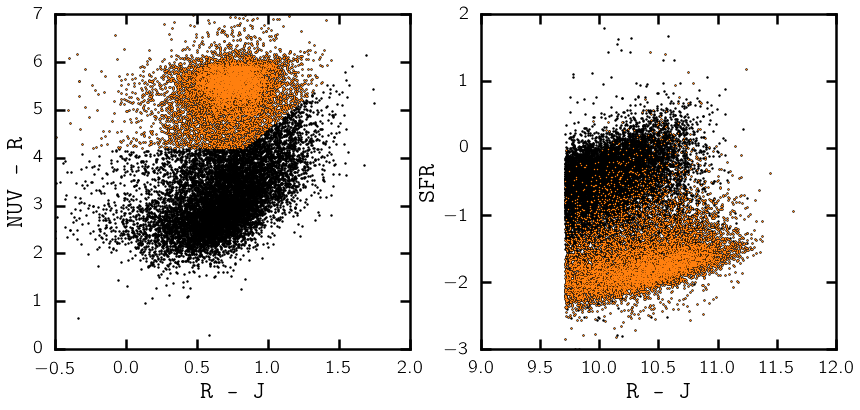

In [34]:
fig = plt.figure(figsize=(14,6))
sub = fig.add_subplot(121)
sub.scatter(vagc['R-J'][m_vagc_ngt], vagc['NUV-R'][m_vagc_ngt], c='k', s=2)
sub.scatter(vagc['R-J'][m_vagc_ngt][nuvrj_Q], vagc['NUV-R'][m_vagc_ngt][nuvrj_Q], c=pretty_colors[3], lw=0, s=2)

sub.set_xlabel('R - J', fontsize=25)
sub.set_xlim([-0.5, 2.])
sub.set_ylabel('NUV - R', fontsize=25)
sub.set_ylim([0., 7.])

sub = fig.add_subplot(122)
sub.scatter(vagc['mass'][m_vagc_ngt], vagc['sfr'][m_vagc_ngt], c='k', s=2)
sub.scatter(vagc['mass'][m_vagc_ngt][nuvrj_Q], vagc['sfr'][m_vagc_ngt][nuvrj_Q], c=pretty_colors[3], lw=0, s=2)

sub.set_xlabel('R - J', fontsize=25)
sub.set_xlim([9., 12.])
sub.set_ylabel('SFR', fontsize=25)
sub.set_ylim([-3., 2.])

Doesn't look too bad... 

## Now lets see if there's an impact on $f_Q(M_*)$ 

In [37]:
def fQ(mass, sfq): 
    ''' calculate quiescent fraction given stellar mass
    and SF/Q classification
    '''
    assert len(mass) == len(sfq)
    m_low = np.arange(9., 12., 0.1)
    m_high = m_low + 0.1
    
    fq = np.zeros(len(m_low))
    for i_m in range(len(m_low)): 
        in_bin = np.where((mass >= m_low[i_m]) & (mass < m_high[i_m]))
        if len(in_bin[0]) > 0: 
            isQ = np.where(sfq[in_bin] == 'q')
            fq[i_m] = np.float(len(isQ[0]))/np.float(len(in_bin[0]))
    return 0.5*(m_low+m_high), fq

In [38]:
# SFR-M fQ
sfq_sfrm = np.repeat('sf', len(m_vagc_ngt))
sfq_sfrm[sfrm_Q] = 'q'

M_sfrm, fq_sfrm = fQ(vagc['mass'][m_vagc_ngt], sfq_sfrm)

In [40]:
# (NUV-R) vs (R-J) fQ
sfq_nuvrj = np.repeat('sf', len(m_vagc_ngt))
sfq_nuvrj[nuvrj_Q] = 'q'

M_nuvrj, fq_nuvrj = fQ(vagc['mass'][m_vagc_ngt], sfq_nuvrj)

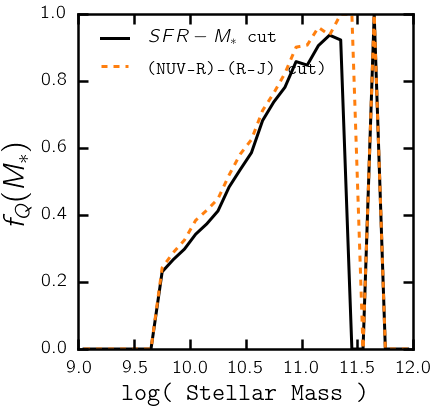

In [46]:
# compare the two fQs
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

sub.plot(M_sfrm, fq_sfrm, c='k', lw=3, label='$SFR-M_*$ cut')
sub.plot(M_nuvrj, fq_nuvrj, c=pretty_colors[3], ls='--', lw=3, label='(NUV-R)-(R-J) cut)')

sub.set_xlim([9.,12.])
sub.set_xlabel('log( Stellar Mass )', fontsize=25)
sub.set_ylim([0., 1.])
sub.set_ylabel('$f_Q(M_*)$', fontsize=30)
sub.legend(loc='upper left')

# $f_Q^{SFR-M_*}$ and $f_Q^{(NUV-R)-(R-J)}$ are in good agreement!